# Try Li Plating Sub Models

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_model/"
res_DIR = "../data/results_model/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
    }
)
spm_li = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
    }
)

spm_li_r = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "reversible",
    }
)

spm_li_pr = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "partially reversible",
    }
)

spme = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
    }
)
spme_li = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
    }
)
# spm.print_parameter_info()
param=spm_li.param

In [4]:
cell = 4
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

25


In [5]:
parameter_values.update(
    {
      "Negative electrode active material volume fraction": eps_n_data,
      "Positive electrode active material volume fraction": eps_p_data,
      "Positive electrode LAM constant proportional term [s-1]": 1.27152e-07,
      "Negative electrode LAM constant proportional term [s-1]": 1.27272e-06,
      "Positive electrode LAM constant exponential term": 1.1992,
      "Negative electrode LAM constant exponential term": 1.1992,
      "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
      "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
      "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
      "Lithium plating kinetic rate constant [m.s-1]": 1e-11,
      # "Lithium plating transfer coefficient": 0.65,
      # "Exchange-current density for plating [A.m-2]":0.002,
      # "Lithium plating transfer coefficient": 0.7,
      # "Dead lithium decay constant [s-1]": 1E-4,
    },
    check_already_exists=False,
)

In [6]:
parameter_values.search('sei')

Initial inner SEI thickness [m]	2.5e-09
Initial outer SEI thickness [m]	2.5e-09
Inner SEI electron conductivity [S.m-1]	8.95e-14
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Inner SEI open-circuit potential [V]	0.1
Inner SEI partial molar volume [m3.mol-1]	9.585e-05
Inner SEI reaction proportion	0.5
Outer SEI open-circuit potential [V]	0.8
Outer SEI partial molar volume [m3.mol-1]	9.585e-05
Outer SEI solvent diffusivity [m2.s-1]	2.5000000000000002e-22
Ratio of lithium moles to SEI moles	2.0
SEI growth activation energy [J.mol-1]	18742.2275
SEI kinetic rate constant [m.s-1]	4.60788219e-16
SEI open-circuit potential [V]	0.4
SEI reaction exchange current density [A.m-2]	1.5e-07
SEI resistivity [Ohm.m]	200000.0


In [7]:
# c_rate_d = '2C'
# c_rate_c = '1.5C'
c_rate_c ='C/5'
SOC_0 = 0

In [8]:
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
# pybamm.set_logging_level("INFO")
# pybamm.set_logging_level("VERBOSE")
# pybamm.set_logging_level("SPAM")
experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50"
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)

# experiment = pybamm.Experiment(
#     [
#         (
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50",
#          "Rest for 5 min",
#          "Discharge at "+c_rate_d+" until 3V",
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
# SOC_0 = 0 

# experiment = pybamm.Experiment(
#     [
#         (
#         #  "Charge at "+c_rate_c+" until 4.2V", 
#         #  "Hold at 4.2V until C/50",
#         #  "Rest for 5 min",
#          "Discharge at "+c_rate_d+" until 3V",
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
# SOC_0 = 1

In [9]:
sim_long = pybamm.Simulation(spm_li, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution1 = sol_long

2022-12-02 12:35:13.237 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (19.645 ms elapsed) --------------------
2022-12-02 12:35:13.238 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/2: Charge at C/5 until 4.2V
2022-12-02 12:35:13.525 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/2: Hold at 4.2V until C/50
2022-12-02 12:35:13.842 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.850 Ah (originally 4.850 Ah, will stop at 2.425 Ah)
2022-12-02 12:35:13.843 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 623.997 ms


In [10]:
# parameter_values.update(
#     {
#     #   "Exchange-current density for plating [A.m-2]":0.001,
#     #   "Lithium plating transfer coefficient": 0.5,
#     #   "Dead lithium decay constant [s-1]": 1E-4,
#         # "Exchange-current density for stripping [A.m-2]": 0.00005,
#     },
#     check_already_exists=False,
# )
c_rate_c ='1.5C'
experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50"
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)

sim_long = pybamm.Simulation(spm_li, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution2 = sol_long

2022-12-02 12:35:15.057 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (12.277 ms elapsed) --------------------
2022-12-02 12:35:15.057 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/2: Charge at 1.5C until 4.2V
2022-12-02 12:35:15.152 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/2: Hold at 4.2V until C/50
2022-12-02 12:35:15.501 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.851 Ah (originally 4.851 Ah, will stop at 2.425 Ah)
2022-12-02 12:35:15.502 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 456.808 ms


In [11]:
parameter_values.update(
    {
      # "Exchange-current density for plating [A.m-2]":0.002,
      # "Lithium plating transfer coefficient": 0.7,
      # "Dead lithium decay rate [s-1]": 1E-4,
      "Initial outer SEI thickness [m]": 50*5e-09,
    },
    check_already_exists=False,
)

sim_long = pybamm.Simulation(spm_li, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution3 = sol_long

2022-12-02 12:35:16.474 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (11.158 ms elapsed) --------------------
2022-12-02 12:35:16.475 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/2: Charge at 1.5C until 4.2V
2022-12-02 12:35:16.566 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/2: Hold at 4.2V until C/50
2022-12-02 12:35:16.863 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.851 Ah (originally 4.851 Ah, will stop at 2.425 Ah)
2022-12-02 12:35:16.864 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 399.301 ms


In [12]:
# spm_li.variables.search("sei")

In [13]:
def plot_vars(solution):
    t =  solution["Time [s]"].entries
    V =  solution["Terminal voltage [V]"].entries
    I =  solution["Current [A]"].entries
    Q = -solution['Discharge capacity [A.h]'].entries
    Q_Li = solution["Loss of capacity to lithium plating [A.h]"].entries
    I_Li = solution["X-averaged lithium plating interfacial current density"].entries

    I_de = solution["X-averaged negative electrode interfacial current density"].entries
    I_st = solution["X-averaged lithium plating interfacial current density"].entries
    I_to = solution["Sum of x-averaged negative electrode volumetric interfacial current densities"].entries

    phi_seif = solution["X-averaged SEI film overpotential [V]"].entries
    phi_sei  = solution["X-averaged negative electrode sei reaction overpotential [V]"].entries
    # phi_sei = 0
    phi_pl  = solution["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
    phi_pl_nd  = solution["X-averaged negative electrode lithium plating reaction overpotential"].entries
    phi_del = solution["X-averaged negative electrode surface potential difference [V]"].entries

    return t,V,I,Q,Q_Li,I_Li,I_de,I_st,I_to,phi_seif,phi_sei,phi_pl,phi_del

In [14]:
t1,V1,I1,Q1,Q_Li1,I_Li1,I_de1,I_st1,I_to1,phi_seif1,phi_sei1,phi_pl1,phi_del1 = plot_vars(solution1)
t2,V2,I2,Q2,Q_Li2,I_Li2,I_de2,I_st2,I_to2,phi_seif2,phi_sei2,phi_pl2,phi_del2 = plot_vars(solution2)
# t3,V3,I3,Q3,Q_Li3,I_Li3,I_de3,I_st3,I_to3,phi_seif3,phi_sei3,phi_pl3,phi_del3 = plot_vars(solution3)

In [18]:
linestyles = ["dashed", "dotted", "solid"]
colors = ["tab:purple", "tab:cyan", "tab:red", "tab:green", "tab:blue"]

In [19]:
U_sei = pybamm.Parameter(f"SEI open-circuit potential [V]")
parameter_values.evaluate(U_sei)

0.4

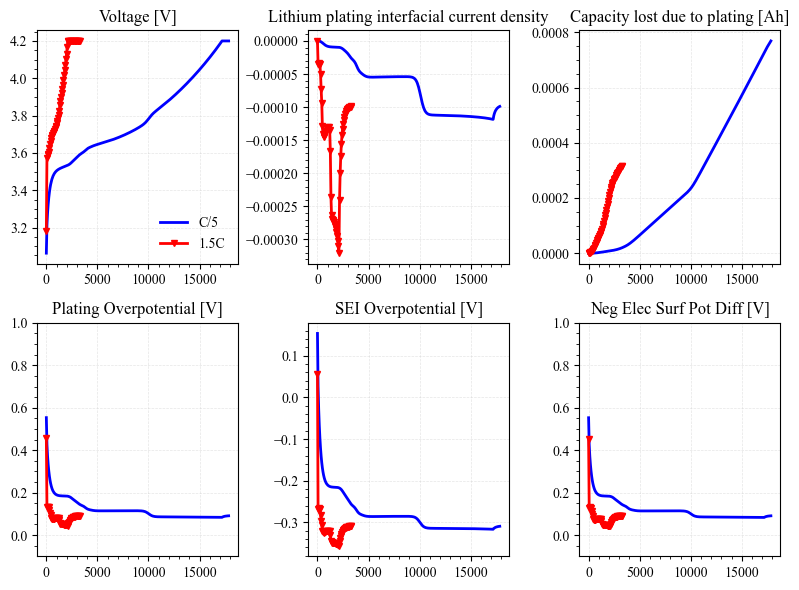

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
ax1 = axes.flat[0]
ax1.plot(t1,V1,'b')
ax1.plot(t2,V2,'rv-')
ax1.set_title('Voltage [V]')
ax3 = axes.flat[3]
ax3.plot(t1,phi_pl1,'b')
ax3.plot(t2,phi_pl2,'rv-')
ax3.set_ylim([-0.1,1])
ax3.set_title('Plating Overpotential [V]')
ax4 = axes.flat[4]
ax4.plot(t1,phi_sei1,'b')
ax4.plot(t2,phi_sei2,'rv-')
ax4.set_title('SEI Overpotential [V]')
ax2 = axes.flat[2]
ax2.plot(t1,Q_Li1,'b')
ax2.plot(t2,Q_Li2,'rv-')
ax2.set_title('Capacity lost due to plating [Ah]')
ax3=axes.flat[1]
ax3.plot(t1,I_Li1,'b')
ax3.plot(t2,I_Li2,'rv-')
ax3.set_title('Lithium plating interfacial current density')
ax5=axes.flat[5]
ax5.plot(t1,phi_del1,'b')
ax5.plot(t2,phi_del2,'rv-')

# ax1.plot(t3,V3,'g--')
# ax3.plot(t3,phi_pl3,'g--')
# ax4.plot(t3,phi_sei3,'g--')
# ax2.plot(t3,Q_Li3,'g--')
# ax3.plot(t3,I_Li3,'g--')
# ax5.plot(t3,phi_del3,'g--')
ax5.set_title('Neg Elec Surf Pot Diff [V]')
ax5.set_ylim([-0.1,1])
# ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
ax1.legend(['C/5','1.5C'])
# ax1.legend(['SPM','SPMe'])
fig.tight_layout()
# plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
# plt.savefig(fig_DIR+'plating_compare_crate'+'.png')
plt.savefig(fig_DIR+'plating_compare_spme'+'.png')

In [21]:
# spm_li.variables.search("SEI")

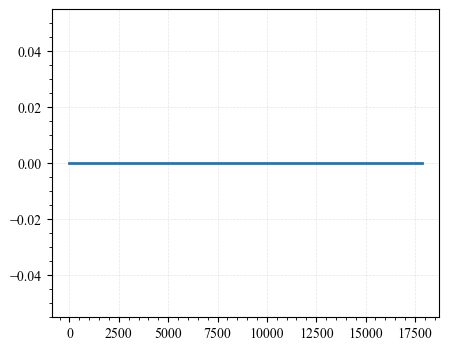

In [22]:
Tn_1 = solution1["X-averaged negative electrode temperature"].entries
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
ax1 = axes
ax1.plot(t1,Tn_1)